# Can AI predict the MPAA rating of a movie based only on its description?

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D

%matplotlib inline
warnings.filterwarnings('ignore')

Download the [Rotten Tomatoes Movie Database](https://www.kaggle.com/ayushkalla1/rotten-tomatoes-movie-database/) on Kaggle

In [0]:
from google.colab import drive
drive.mount('/content/drive')
plots_df = pd.read_csv('/content/drive/My Drive/data_science/nlp/datasets/rotten_tomatoes_all_movies.csv')
plots_df.head(15)

In [4]:
subset_df = plots_df[['Title', 'Rating', 'Description']]
subset_df.head(20)

,Title,Rating,Description
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ..."
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...
4,Apocalypse Now,R,One of a cluster of late-1970s films about the...
5,Mortdecai,R,"Juggling some angry Russians, the British Mi5,..."
6,The Hurt Locker,R,Based on the personal wartime experiences of j...
7,The Little Vampire 3D,NR,"THE LITTLE VAMPIRE, based on the characters fr..."
8,The Fortune,PG,Three's a crowd in Mike Nichols's period caper...
9,Heaven Knows Mr. Allison,NR,A two-person character study directed by John ...


In [5]:
subset_df['Rating'].unique()

array(['PG-13', 'R', 'NR', 'PG', 'G', 'NC17'], dtype=object)

In [0]:
def preprocess_text(sen):
    sentence = re.sub('[^a-zA-Z]',  ' ', sen)
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

X = []
sentences = subset_df['Description'].tolist()
for sen in sentences:
    X.append(preprocess_text(str(sen)))

In [0]:
y = subset_df['Rating']
le = LabelEncoder()
y = le.fit_transform(y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 400

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

[5, 20, 8561, 267, 265, 5774, 7, 9888, 557, 8, 1, 4688, 2, 6735, 567, 3, 3421, 297, 535, 8562, 3, 1, 91, 3, 1963, 8958, 2654, 182, 3, 1168, 2, 9, 3826, 9, 129, 147, 21, 10, 5514, 417, 2093, 4, 3080, 60, 82, 1, 3345, 1358, 122, 2795, 8765, 1, 557, 3, 145, 3, 1187, 709, 87, 50, 2, 101, 1, 43, 29, 5, 462, 4, 37, 1, 56, 4, 1268, 1, 3131, 2654, 1, 110, 5940, 62, 326, 7719, 2, 467, 193, 393, 54]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    

Download the [6B GloVe word embedding](https://nlp.stanford.edu/projects/glove/) - make sure you grab [the 6B version](http://nlp.stanford.edu/data/glove.6B.zip)!

In [0]:
#
# Hat tip: https://stackabuse.com/python-for-nlp-creating-multi-data-type-classification-models-with-keras/
#

embeddings_dictionary = dict()
glove = open('/content/drive/My Drive/data_science/nlp/glove.6B.100d.txt', encoding='utf8')

for line in glove:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
    
glove.close()

embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
# build the neural network model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         5805700   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 5,923,722
Trainable params: 118,022
Non-trainable params: 5,805,700
_________________________________________________________________


In [26]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=35, validation_split=0.2, verbose=1)

Train on 19078 samples, validate on 4770 samples
Epoch 1/35
19078/19078 [==============================] - 115s 6ms/step - loss: 1.4579 - acc: 0.3727 - val_loss: 1.4211 - val_acc: 0.3675
Epoch 2/35
19078/19078 [==============================] - 113s 6ms/step - loss: 1.3954 - acc: 0.4004 - val_loss: 1.3369 - val_acc: 0.4208
Epoch 3/35
19078/19078 [==============================] - 113s 6ms/step - loss: 1.3047 - acc: 0.4466 - val_loss: 1.2690 - val_acc: 0.4564
Epoch 4/35
19078/19078 [==============================] - 113s 6ms/step - loss: 1.2590 - acc: 0.4662 - val_loss: 1.2384 - val_acc: 0.4801
Epoch 5/35
19078/19078 [==============================] - 113s 6ms/step - loss: 1.2303 - acc: 0.4818 - val_loss: 1.2061 - val_acc: 0.4927
Epoch 6/35
19078/19078 [==============================] - 113s 6ms/step - loss: 1.2089 - acc: 0.4953 - val_loss: 1.1917 - val_acc: 0.5008
Epoch 7/35
19078/19078 [==============================] - 113s 6ms/step - loss: 1.1830 - acc: 0.5099 - val_loss: 1.1657 - v

In [27]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

5962/5962 [==============================] - 25s 4ms/step
loss:  0.8240444696977289
accuracy:  0.715028513901508


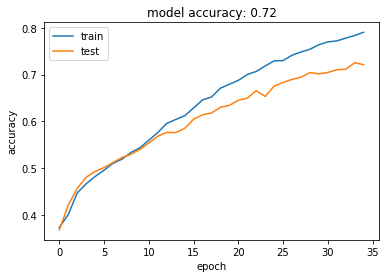

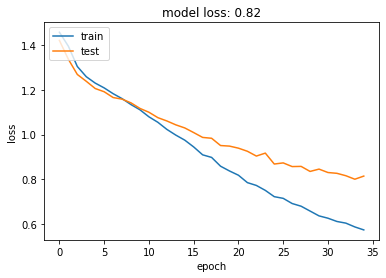

In [37]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy: {:.2f}'.format(acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss: {:.2f}'.format(loss))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save('movie_description_classifier.h5')

# Make predictions on unseen data

In [36]:
''' Cabin in the Woods (R) '''
synopsis = 'Five friends go for a break at a remote cabin, where they get more than they bargained for, discovering the truth behind the cabin in the woods.'

''' Walking Tall (PG-13) '''
# synopsis = 'Chris Vaughn is a retired soldier who returns to his hometown to make a new life for himself, only to discover his wealthy high school rival, Jay Hamilton, has closed the once-prosperous lumber mill to turn the town resources towards his own criminal gains. The town is now overrun with crime, drugs and violence. Enlisting the help of his old pal Ray Templeton, Chris gets elected sheriff and vows to shut down Hamilton operations. His actions endanger his family and threaten his own life, but Chris refuses to back down until his hometown once again feels like home.'

''' The Hurt Locker (R) '''
# synopsis = 'Based on the personal wartime experiences of journalist Mark Boal (who adapted his experiences with a bomb squad into a fact-based, yet fictional story), director Kathryn Bigelow Iraq War-set action thriller The Hurt Locker presents the conflict in the Middle East from the perspective of those who witnessed the fighting firsthand -- the soldiers. As an elite Army Explosive Ordnance Disposal team tactfully navigates the streets of present-day Iraq, they face the constant threat of death from incoming bombs and sharp-shooting snipers. In Baghdad, roadside bombs are a common danger. The Army is working to make the city a safer place for Americans and Iraqis, so when it comes to dismantling IEDs (improvised explosive devices) the Explosive Ordnance Disposal (EOD) crew is always on their game. But protecting the public easy when there no room for error, and every second spent dismantling a bomb is another second spent flirting with death. Now, as three fearless bomb technicians take on the most dangerous job in Baghdad, it only a matter of time before one of them gets sent to the hurt locker. Jeremy Renner, Guy Pearce, and Ralph Fiennes star.'

''' Revenge of the Ninja (R) '''
# synopsis = 'After his family is killed in Japan by ninjas, Cho and his son Kane come to America to start a new life. He opens a doll shop but is unwittingly importing heroin in the dolls. When he finds out that his friend has betrayed him, Cho must prepare for the ultimate battle he has ever been involved in.'

''' The Lion King (G) '''
''' NOTE: the two summaries are combined for the 1994 and 2019 films '''
# synopsis = 'A Lion cub crown prince is tricked by a treacherous uncle into thinking he caused his father death and flees into exile in despair, only to learn in adulthood his identity and his responsibilities. After the murder of his father, a young lion prince flees his kingdom only to learn the true meaning of responsibility and bravery.'

''' Scarface (R) '''
synopsis = X[1974]
print(synopsis)


# dictionary of key-value mappings for MPAA ratings
mpaa_ratings = { 0:'G', 1:'NC-17', 2:'NR', 3:'PG', 4:'PG-13', 5:'R' }

synopsis = tokenizer.texts_to_sequences(synopsis)

flat_list = []
for sublist in synopsis:
    for item in sublist:
        flat_list.append(item)

synopsis = pad_sequences([flat_list], maxlen=maxlen)
# print(synopsis)
prediction = model.predict_classes(synopsis)
# print(prediction)
print('I predict that the MPAA would give your movie description a rating of {}'.format(mpaa_ratings[prediction[0]]))

Al Pacino stars as Tony Montana an exiled Cuban criminal who goes to work for Miami drug lord Robert Loggia Montana rises to the top of Florida crime chain appropriating Loggia cokehead mistress Michelle Pfeiffer in the process Howard Hawks Marks the Spot motif in depicting the story line many murders is dispensed with in the Scarface instead we are inundated with blood by the bucketful especially in the now infamous buzz saw scene One carry over from the original Scarface is Tony Montana incestuous yearnings for his sister Gina Mary Elizabeth Mastrantonio The screenplay for the Scarface was written by Oliver Stone Hal Erickson Rovi
I predict that the MPAA would give your movie description a rating of PG-13
